## Cerebellar Microcircuit Simulation Notebook 

In this Notebook, the user can run a pyNEST implementation of our scaffold model of cerebellar microcircuit. 


In [1]:
! pip install -q --upgrade "hbp-service-client==1.0.0"

#### **<font color="red">You might need to restart the kernel at this point...</font>**


First, use module *os* to clean workspace from .gdf or .dat files (file storing spikes and voltage traces from previous simulations, respectively

In [2]:
import os

def remove_files():
    for f in os.listdir('.'):
        if '.gdf' in f or '.dat' in f:
            os.remove(f)
            
remove_files()

A parameter file and a *.hdf5* file, containing positions and connections data, are downloaded from cerebellum storage Collab.  

In [3]:
# Load file with positions and connections data
client = get_hbp_service_client()
cerebellum_storage = '/8124'
path = cerebellum_storage + '/BSP_usecases/Network_files/'
hdf5_file = 'connected_scaffold_full_dcn_200.0x200.0.hdf5'
client.storage.download_file(path+hdf5_file, hdf5_file)
client.storage.download_file(path+'scaffold_params.py', 'scaffold_params.py')

### Reading connectivity data 
We use PyNEST as simulator; 
to exploit multithreading, we use the *multiprocessing* Python module to split computations among available cores
Informations about connectivity are readen from the _.hdf5_ file 

In [22]:
import h5py
import nest
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scaffold_params import *
from multiprocessing import cpu_count
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

nest.ResetKernel()
nest.set_verbosity('M_ERROR')
nest.SetKernelStatus({"local_num_threads" : cpu_count()})

%matplotlib inline

f = h5py.File(hdf5_file, 'r+')
# Take positions
positions = np.array(f['positions'])


### Load connections:
## this method is still very 'manual'; btw, for the moment we can keep it and improve it later
# from granules
aa_goc = np.array(f['connections/aa_goc']) # from granule-ascending axon to golgi cells
aa_pc = np.array(f['connections/aa_pc']) # from granule-ascending axon to Purkinje cells
pf_bc = np.array(f['connections/pf_bc']) # from granule-parallel fibers to basket cells
pf_goc = np.array(f['connections/pf_goc']) # from granule-parallel fibers to golgi cells
pf_pc = np.array(f['connections/pf_pc']) # from granule-parallel fibers to Purkinje cells
pf_sc = np.array(f['connections/pf_sc']) # from granule-parallel fibers to stellate cells
# from glomeruli
glom_goc = np.array(f['connections/glom_goc']) # from glomeruli to golgi cells
glom_grc = np.array(f['connections/glom_grc']) # from glomeruli to granule cells -- remember to add few lines of code to connectome.py for it
# from Golgi cells
goc_glom = np.array(f['connections/goc_glom']) # from golgi cells to glomeruli
goc_grc = np.array(f['connections/goc_grc']) # from golgi cells to glomeruli
# from basket cells
bc_pc = np.array(f['connections/bc_pc']) # from basket to Purkinje cells
gj_bc = np.array(f['connections/gj_bc']) # gap junctions among basket cells
# from stellate cells
gj_sc = np.array(f['connections/gj_sc']) # gap junctions among stellate cells
sc_pc = np.array(f['connections/sc_pc']) # from stellate cells to Purkinje cells
# from Purkinje to deep cerebellar nuclei
pc_dcn = np.array(f['connections/pc_dcn'])
f.close()

### Creating population of neurons
Instantiate conductance based integrate and fire models for each cell type. 
The only exception is represented by Glomeruli; these are not actual cells but just 'relays', used to deliver input spikes to other cells. Here, Glomeruli are created as *parrot_neurons*

In [23]:
### Creating neuron populations ###
# Create stimulus
# Create a dictionary where keys = nrntype IDs, values = cell names (strings)
id_2_cell_type = {val: key for key, val in cell_type_ID.iteritems()}
# Sort nrntype IDs 
sorted_nrn_types = sorted(list(cell_type_ID.values()))
# Create a dictionary; keys = cell names, values = lists to store neuron models
neuron_models = {key: [] for key in cell_type_ID.iterkeys()}

# At the moment, all the cells are LIF models;
# with the only exception of Glomeruli (not cells, just modeled as
# relays; i.e., parrot neurons)
for cell_id in sorted_nrn_types:
    cell_name = id_2_cell_type[cell_id] 
    if cell_name  != 'glomerulus':
        if cell_name not in nest.Models():
            nest.CopyModel('iaf_cond_exp', cell_name)
        if cell_name == 'golgi':
            nest.SetDefaults(cell_name, {
                't_ref': 2.0, #ms 
                'C_m' : 76.0, #pF
                'V_th' : -55.0, #mV
                'V_reset': -75.0, #mV
                'g_L': 3.6, #nS
                'E_L' : -65.0, #mV
                'I_e': 36.75, #pA # tonic 6-12 Hz
                'tau_syn_ex': 0.5,
                'tau_syn_in': 10.0})
        elif cell_name == 'granule':
            nest.SetDefaults(cell_name, {
                't_ref': 1.5, #ms 
                'C_m' : 3.0, #pF
                'V_th' : -42.0, #mV
                'V_reset': -84.0, #mV
                'g_L': 1.5, #nS
                'E_L' : -74.0, #mV
                'I_e': 0.0, #pA 
                'tau_syn_ex': 0.5,
                'tau_syn_in': 10.0})
        elif cell_name == 'purkinje':
            nest.SetDefaults(cell_name, {
                't_ref': 0.8, #ms 
                'C_m' : 620.0, #pF
                'V_th' : -47.0, #mV
                'V_reset': -72.0, #mV
                'g_L': 7.0, #nS
                'E_L' : -62.0, #mV
                'I_e': 850.0, #pA #tonic 40-70 Hz
                'tau_syn_ex': 0.5,
                'tau_syn_in': 10.0})
        elif cell_name == 'stellate' or cell_name == 'basket':
            nest.SetDefaults(cell_name, {
                't_ref': 1.59, #ms 
                'C_m' : 5.0, #pF
                'V_th' : -42.0, #mV
                'V_reset': -60.0, #mV
                'g_L': 1.0, #nS
                'E_L' : -50.0, #mV
                'I_e': 9.0, #pA #tonic 40-70 Hz
                'tau_syn_ex': 0.5,
                'tau_syn_in': 10.0})
        else: # The case of DCpN
            nest.SetDefaults(cell_name, {
                't_ref': 3.7,
                'C_m' : 89.0,  #pF
                'V_th' : -48.0,
                'V_reset': -69.0,
                'g_L': 1.56,
                'E_L':-59.0,  #mV
                'I_e': 26.75 , #pA     #tonic 10 Hz
                'tau_syn_ex': 0.5,
                'tau_syn_in': 10.0})

    else:
        if cell_name not in nest.Models():
            nest.CopyModel('parrot_neuron', cell_name)
            
    cell_pos = positions[positions[:,1]==cell_id, :]
    neuron_models[cell_name] = nest.Create(cell_name, cell_pos.shape[0])

### Synaptic connections

Here we create synaptic connections among neurons; generally this is the longest part of the whole simulation. It should take 12 to 14 minutes to finish. 
A message will be printed below the next cell when each connection type is done

In [26]:
%%time 
def connect_neuron(conn_mat, pre, post, syn_param, conn_param='one_to_one'):
    '''This function connets 2 neuron populations:
    conn_mat = n x 2 matrix; first column contains GIDs
              of presynaptic neurons, the second contains GIDS of
              postsynaptic ones. 
    pre : models of presynaptic neurons, 
    post : models of postsynaptic neurons,
    '''
    pre_idx = [np.where(pre==x)[0][0] for x in conn_mat[:,0]+1]
    post_idx = [np.where(post==x)[0][0] for x in conn_mat[:,1]+1]
    nest.Connect(map(pre.__getitem__, pre_idx), map(post.__getitem__, post_idx), conn_spec = conn_param, syn_spec = syn_param)
    nest.GetConnections(pre, post)


# 1 - From granule-aa to Golgi cells
syn_param = {"model" : "static_synapse", "weight" : 20.0, "delay": 0.5}
connect_neuron(aa_goc, neuron_models['granule'], neuron_models['golgi'], syn_param=syn_param)

print "Connections from {} to {} done".format('granule-aa', 'golgi')

# 2 - From granule-aa to Purkinje cells
syn_param = {"model" : "static_synapse", "weight" : 20.0, "delay": 0.9}
connect_neuron(aa_pc, neuron_models['granule'], neuron_models['purkinje'], syn_param=syn_param)

print "Connections from {} to {} done".format('granule-aa', 'Purkinje')

# Original weigth from pfs to all targets: 20.0
# 3 - From granule-parallel fibers to basket cells
syn_param = {"model" : "static_synapse", "weight" : 5.0, "delay": 1.0}
connect_neuron(pf_bc, neuron_models['granule'], neuron_models['basket'], syn_param=syn_param)

print "Connections from {} to {} done".format('granule-pfs', 'basket')

# 4 - From granule-parallel fibers to Golgi cells
syn_param = {"model" : "static_synapse", "weight" : 5.0, "delay": 1.0}
connect_neuron(pf_goc, neuron_models['granule'], neuron_models['golgi'], syn_param=syn_param)

print "Connections from {} to {} done".format('granule-pfs', 'golgi')

# 5 - From granule-parallel fibers to Purkinje cells
syn_param = {"model" : "static_synapse", "weight" : 5.0, "delay": 1.0}
connect_neuron(pf_pc, neuron_models['granule'], neuron_models['purkinje'], syn_param=syn_param)

print "Connections from {} to {} done".format('granule-pfs', 'Purkinje')

# 6 - From granule-parallel fibers to stellate cells
syn_param = {"model" : "static_synapse", "weight" : 5.0, "delay": 1.0}
connect_neuron(pf_sc, neuron_models['granule'], neuron_models['stellate'], syn_param=syn_param)

print "Connections from {} to {} done".format('granule-pfs', 'stellate')

# 7 - From glomeruli to Golgi cells
syn_param = {"model" : "static_synapse", "weight" : 20.0, "delay": 0.5}
connect_neuron(glom_goc, neuron_models['glomerulus'], neuron_models['golgi'], syn_param=syn_param)

print "Connections from {} to {} done".format('glomerulus', 'golgi')

# 8 - From glomeruli to granule cells
syn_param = {"model" : "static_synapse", "weight" : 20.0, "delay": 0.5}
connect_neuron(glom_grc, neuron_models['glomerulus'], neuron_models['granule'], syn_param=syn_param)

print "Connections from {} to {} done".format('glomerulus', 'granule')

# 9 - From golgi cells to granules
# Original : -10.0
syn_param = {"model" : "static_synapse", "weight" : -10.0, "delay": 0.5}
connect_neuron(goc_grc, neuron_models['golgi'], neuron_models['granule'], syn_param=syn_param)

print "Connections from {} to {} done".format('golgi', 'granule')

# 10 - From basket to purkinje
# Original : -10.
syn_param = {"model" : "static_synapse", "weight" : -5.0, "delay": 0.5}
connect_neuron(bc_pc, neuron_models['basket'], neuron_models['purkinje'], syn_param=syn_param)

print "Connections from {} to {} done".format('basket', 'purkinje')

# 11 - From basket to basket (gap)
# Original weight = -10.0 
syn_param = {"model" : "static_synapse", "weight" : -5.0, "delay": 0.5}
connect_neuron(gj_bc, neuron_models['basket'], neuron_models['basket'], syn_param=syn_param)

print "Connections from {} to {} done".format('basket', 'basket')

# 12 - From stellate to purkinje
# Original: -10.0
syn_param = {"model" : "static_synapse", "weight" : -5.0, "delay": 0.5}
connect_neuron(sc_pc, neuron_models['stellate'], neuron_models['purkinje'], syn_param=syn_param)

print "Connections from {} to {} done".format('stellate', 'purkinje')

# 13 - From stellate to stellate (gap)
# original weight = -10.0
syn_param = {"model" : "static_synapse", "weight" : -5.0, "delay": 0.5}
connect_neuron(gj_sc, neuron_models['stellate'], neuron_models['stellate'], syn_param=syn_param)

print "Connections from {} to {} done".format('stellate', 'stellate')

# 14 - From Purkinje to deep cerebellar nuclei
syn_param = {"model" : "static_synapse", "weight" : -2.0, "delay": 1.0}
connect_neuron(pc_dcn, neuron_models['purkinje'], neuron_models['dcn'], syn_param=syn_param)

print "Connections from {} to {} done".format('purkinje', 'dcn')


Connections from granule-aa to golgi done
Connections from granule-aa to Purkinje done
Connections from granule-pfs to basket done
Connections from granule-pfs to golgi done
Connections from granule-pfs to Purkinje done
Connections from granule-pfs to stellate done
Connections from glomerulus to golgi done
Connections from glomerulus to granule done
Connections from golgi to granule done
Connections from basket to purkinje done
Connections from basket to basket done
Connections from stellate to purkinje done
Connections from stellate to stellate done
Connections from purkinje to dcn done
CPU times: user 10min 21s, sys: 720 ms, total: 10min 22s
Wall time: 9min 36s


### Define stimulus properties (user)

Into the next cell, the user can define the parameters value for the simulation. A 3-dimensional area within the granular layer is defined and the glomeruli included into this area will be stimulated with a spike train. The user can set the following parameters:
1. RECORD_VM: by default, spike data are recorded. If you want to record voltage-traces too, please set this variable to 'True'
2. TOT_DURATION: duration of whole simulation, in milliseconds. 
3. STIM_START: when the external stimulation (a spike train) should start.
4. STIM_END : when the external stimulation should end (of course, STIM_END cannot be higher than TOT_DURATION). 
5. STIM_FREQ : frequence of the delivered spike train (in Hz)
6. RADIUS: the radius of the spherical volume that will be stimulated

In [13]:
RECORD_VM = True
TOT_DURATION = 500. # mseconds
STIM_START = 300. # beginning of stimulation
STIM_END = 330.   # end of stimulation
STIM_FREQ = 400. # Frequency in Hz
RADIUS = 30.5 # Micron

The following cell return a plot displaying the area that you selected for stimulation (left) and the spike-pattern that will be delivered to the network (right; the figure will take a few seconds to appear)

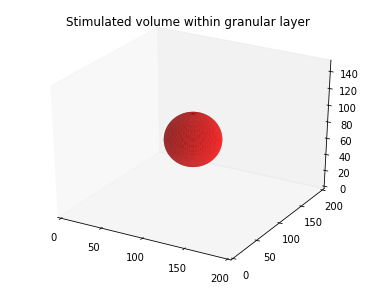

In [17]:
from __future__ import division
plt.interactive(True)

fig = plt.figure(figsize=(14,6))

spike_nums = np.int(np.round((STIM_FREQ * (STIM_END - STIM_START)) / 1000.))
stim_array = np.round(np.linspace(STIM_START, STIM_END, spike_nums))

arr_to_plot = np.zeros((int(TOT_DURATION)))
arr_to_plot[stim_array.astype(int)] = 1

origin = np.array([100., 100., 75.])
phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = RADIUS*np.sin(phi)*np.cos(theta)+origin[0]
y = RADIUS*np.sin(phi)*np.sin(theta)+origin[1]
z = RADIUS*np.cos(phi)+origin[2]


ax = fig.add_subplot(1, 2, 1, projection='3d')
upper_plane_lims = int(np.ceil(np.max(positions[:,2]))) 
ax.plot_surface(x, y, z, rstride=1, cstride=1, color='red', alpha=0.7, linewidth=0)
ax.set_aspect((int(layers_thick['granular'])) / np.ceil(np.max(positions[:,2])))
ax.set_xlim([0, upper_plane_lims])
ax.set_ylim([0, upper_plane_lims])
ax.set_zlim([0, int(layers_thick['granular'])])
ax.grid(False)
plt.xticks(np.arange(0, upper_plane_lims+1, 50))
plt.yticks(np.arange(0, upper_plane_lims+1, 50))

plt.title('Stimulated volume within granular layer')

ax = fig.add_subplot(1 ,2, 2)
ax.plot(arr_to_plot, 'k')
ax.yaxis.set_visible(False)
ax.set_xlim(250, 380)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Time (msecs)')

plt.title('Input Pattern')

Create stimulus pattern and connect it to Glomeruli

In [ ]:
# Stimulate a bunch of glomeruli within a volume
# Select glomeruli position
gloms_pos = positions[positions[:,1]==cell_type_ID['glomerulus'], :]
# find center of 'glomerular sphere'
x_c, y_c, z_c = np.median(gloms_pos[:,2]), np.median(gloms_pos[:,3]), np.median(gloms_pos[:,4])
#x_c, y_c, z_c = 75., 75., 75.    

# Find glomeruli falling into the selected volume
target_gloms_idx = np.sum((gloms_pos[:,2::] - np.array([x_c, y_c, z_c]))**2, axis=1).__lt__(RADIUS**2)
target_gloms = gloms_pos[target_gloms_idx,0]+1
id_stim = [glom for glom in neuron_models['glomerulus'] if glom in target_gloms]
n = len(target_gloms)
stimulus = nest.Create("spike_generator", n,
                        params = {'spike_times': stim_array})
nest.Connect(stimulus, list(id_stim), conn_spec = 'one_to_one',
             syn_spec = {'weight': 1.0, 'delay': 0.2})

In [ ]:
target_gloms

Create spike detectors and connect them to the cells; if the user selected RECORD_VM, also voltae will be recorded

In [ ]:
## Record spikes from granule and Golgi cells
grc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "granule_spikes"})
goc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "golgi_spikes"})
glom_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "glomerulus_spikes"})
pc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "purkinje_spikes"})
bc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "basket_spikes"})
sc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "stellate_spikes"})
dcn_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "dcn_spikes"})
nest.Connect(neuron_models['granule'], grc_spikes)
nest.Connect(neuron_models['golgi'], goc_spikes)
nest.Connect(neuron_models['glomerulus'], glom_spikes)
nest.Connect(neuron_models['purkinje'], pc_spikes)
nest.Connect(neuron_models['basket'], bc_spikes)
nest.Connect(neuron_models['stellate'], sc_spikes)
nest.Connect(neuron_models['dcn'], dcn_spikes)

        
if RECORD_VM:
    print "Recording membrane voltage"
    grc_vm = nest.Create("multimeter")
    goc_vm = nest.Create("multimeter")
    pc_vm = nest.Create("multimeter")
    bc_vm = nest.Create("multimeter")
    sc_vm = nest.Create("multimeter")                     
    dcn_vm = nest.Create("multimeter")

    nest.SetStatus(grc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "granule_vm"})
    nest.SetStatus(goc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "golgi_vm"})
    nest.SetStatus(pc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "purkinje_vm"})
    nest.SetStatus(bc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "basket_vm"})
    nest.SetStatus(sc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "stellate_vm"})
    nest.SetStatus(dcn_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "dcn_vm"})


    nest.Connect(grc_vm, neuron_models['granule'])
    nest.Connect(goc_vm, neuron_models['golgi'])
    nest.Connect(pc_vm, neuron_models['purkinje'])
    nest.Connect(bc_vm, neuron_models['basket'])
    nest.Connect(sc_vm, neuron_models['stellate'])
    nest.Connect(dcn_vm, neuron_models['dcn'])

### Run simulation

For a short execution time (e.g., 300 ms) should be less than 60s

In [ ]:
nest.Simulate(TOT_DURATION)

GoCspikes = nest.GetStatus(goc_spikes, keys='events')[0]
goc_evs = GoCspikes['senders']
goc_ts = GoCspikes['times']

GrCspikes = nest.GetStatus(grc_spikes, keys='events')[0]
grc_evs = GrCspikes['senders']
grc_ts = GrCspikes['times']

Glomspikes = nest.GetStatus(glom_spikes, keys='events')[0]
glom_evs = Glomspikes['senders']
glom_ts = Glomspikes['times']

Purkinjespikes = nest.GetStatus(pc_spikes, keys='events')[0]
pc_evs = Purkinjespikes['senders']
pc_ts = Purkinjespikes['times']

Basketspikes = nest.GetStatus(bc_spikes, keys='events')[0]
bc_evs = Basketspikes['senders']
bc_ts = Basketspikes['times']

Stellatespikes = nest.GetStatus(sc_spikes, keys='events')[0]
sc_evs = Stellatespikes['senders']
sc_ts = Stellatespikes['times']

Dcnspikes = nest.GetStatus(dcn_spikes, keys='events')[0]
dcn_evs = Dcnspikes['senders']
dcn_ts = Dcnspikes['times']

### Plots

The plot below show the 3d structure of cerebellar cortex and display cells that fired during simulation, using color code to represent firing rate

In [ ]:
def plot_spikes(gids):
    fired_gids = gids-1
    unique, count = np.unique(fired_gids, return_counts=True)
    spike_count = np.array(zip(unique, count))
    fired_pos = positions[np.in1d(positions[:,0], unique), 2::]
    cell_data = np.column_stack((fired_pos, spike_count))
    
    return cell_data

grc_data = plot_spikes(grc_evs)
goc_data = plot_spikes(goc_evs)
pc_data = plot_spikes(pc_evs)
sc_data = plot_spikes(sc_evs)
bc_data = plot_spikes(bc_evs)


traceGrc = go.Scatter3d(
                        x = grc_data[:,0], y = grc_data[:,2], z = grc_data[:,1],
                        name = 'granule',
                        mode = 'markers',
                        marker=dict(size=cells_radius['granule'],
                            color=grc_data[:,4], 
                            colorscale='Reds',
                            symbol='circle',
                            opacity=0.85)
                        )
traceGoc = go.Scatter3d(
                        x = goc_data[:,0], y = goc_data[:,2], z = goc_data[:,1],
                        name = 'Golgi',
                        mode = 'markers',
                        marker=dict(size=cells_radius['golgi'],
                            color=goc_data[:,4], 
                            colorscale='Greens',
                            symbol='circle',
                            opacity=0.35)
                        )
tracePc = go.Scatter3d(
                        x = pc_data[:,0], y = pc_data[:,2], z = pc_data[:,1],
                        name = 'Purkinje',
                        mode = 'markers',
                        marker=dict(size=cells_radius['purkinje'],
                            color=pc_data[:,4], 
                            colorscale='Blues',
                            symbol='circle',
                            opacity=0.85)
                        )
traceSc = go.Scatter3d(
                        x = sc_data[:,0], y = sc_data[:,2], z = sc_data[:,1],
                        name = 'stellate',
                        mode = 'markers',
                        marker=dict(size=cells_radius['stellate'],
                            color=sc_data[:,4], 
                            colorscale='Reds',
                            symbol='circle',
                            opacity=0.55)
                        )
traceBc = go.Scatter3d(
                        x = bc_data[:,0], y = bc_data[:,2], z = bc_data[:,1],
                        name = 'basket',
                        mode = 'markers',
                        marker=dict(size=cells_radius['basket'],
                            color=bc_data[:,4], 
                            colorscale='Reds',
                            symbol='circle',
                            opacity=0.55)
                        )

layout = go.Layout(
                   scene = dict(aspectmode='data')
                  )

data = [traceGrc, traceGoc, tracePc, traceSc, traceBc]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='pc_example')

### Raster Plot 

Below a raster plot of cell spikes for each cell type can be displayed; select the cell type modifying the CELL_TO_PLOT variable.
Cell types are:
1. 'granule'
2. 'golgi'
3. 'pukinje'
4. 'stellate'
5. 'basket'
6. 'dcn'

In [ ]:
CELL_TO_PLOT = 'stellate'

cells = {'granule': [grc_ts, grc_evs],
         'golgi': [goc_ts, goc_evs],
         'purkinje': [pc_ts, pc_evs],
         'stellate': [sc_ts, sc_evs],
         'basket': [bc_ts, bc_evs],
         'dcn': [dcn_ts, dcn_evs]}

trace0 = go.Scatter(
    x = cells[CELL_TO_PLOT][0],
    y = cells[CELL_TO_PLOT][1],
    name = '',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = .2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0]

layout = go.Layout(
              title = 'Spikes raster plot',
              yaxis = dict(title='Neuron GID', zeroline = False),
              xaxis = dict(title='Time [msecs]', zeroline = False, range=[0,TOT_DURATION+1])
             )

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='styled-scatter')

### PSTH plot of spikes 

In [ ]:
def metrics(spikeData, TrialDuration):
    id_spikes = np.sort(np.unique(spikeData,return_index=True))
    k = np.mean(spikeData)
    v = np.var(spikeData)
    delta = 0.1*(np.sqrt(np.abs((k**2)-v)))
    n_bins = int(TrialDuration/delta)
    psth, tms = np.histogram(spikeData, bins = n_bins, range = (0 , TrialDuration))
    
    # absolute frequency
    abs_freq = np.zeros(id_spikes[0].shape[0])
    for idx,i in enumerate(id_spikes[0]):
        count = np.where(spikeData==i)[0]
        abs_freq[idx] = count.shape[0]
    
    # mean frequency
    m_f = (id_spikes[0].shape[0])/TrialDuration
    
    # graph using plotly
    data = [
        go.Bar(
        x = tms[0:len(tms)-1],
        y = psth,
        width = 0.2)
    ]
    
    layout = go.Layout(
            scene = dict(aspectmode='psth'),
            xaxis={'title':'time (ms)'}, 
            yaxis={'title':'number of spikes'}
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='psth')
    
    print "psth: ", psth
    print "tms: ", tms
    print id_spikes
    print "absolute frequency: ", abs_freq
    print "mean frequency: ", m_f
    
    return tms

In [ ]:
metrics(cells[CELL_TO_PLOT][0], TOT_DURATION)

### Save data to Collab storage

Executing the following cell is optional; if you want to download spike (.gdf) and / or voltage (.dat) files for further analysis, the next code snippet will save data into the storage (this might take a few minutes)

In [ ]:
from datetime import datetime

local_storage = get_collab_storage_path()
dirname = local_storage+'/nest_sim_'+datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
client.storage.mkdir(dirname)
for nest_file in os.listdir('.'):
    if '.gdf' in nest_file or '.dat' in nest_file:
        client.storage.upload_file(nest_file, dirname+'/'+nest_file, 'text/plain')
        print '{} uploaded'.format(nest_file)